# P3: Limpando dados do OpenStreetMap

* Lieby Cardoso
                                                
* Região selecionada para o projeto: Belo Horizonte, MG, Brasil  

<img src="BH.jpg" alt="alt text" title="bh">
Fonte: http://www.openstreetmap.org/relation/368782

### Conteúdo
1.	Métodos e ferramentas
2.	Problemas encontrados no mapa
3.  Visão geral dos dados
4.  Idéias adicionais sobre os dados
5.  Conclusão
6.  Referências

### 1.	Métodos e ferramentas
A base dos dados explorados neste projeto é disponibilizada pelo OpenStreetMap e foi extraída com a ajuda da ferramenta API Overpass com as coordenadas -44.3092,-20.0979,-43.6116,-19.7376 que representam a área de Belo Horizonte.

O arquivo foi exportado no formato OSM/XML e foi gerada uma amostra desta base com menos informação para facilitar e agilizar a leitura das informações na fase da auditoria. Script executado: Get_Sample_OSM.py.

A base (map_BH.osm) com todas as informações teve seu conteúdo analisado e os apontamentos e decisões tomadas estão documentadas na seção  2 deste documento.
Script executado: Audit_map_BH.py.

Auditoria dos dados, o arquivo XML foi convertido para JSON. 
Script executado: Dump_map_BH_JSON.py.

Todo o conteúdo do arquivo JSON foi importado para a base BH no banco de dados MongoDB. 

Foram executadas consultas aos dados importados e a inconsistências foram corrigidas.


### 2.	Problemas encontrados no mapa

** Localização da identificação do tipo de rua **

Diferente dos exercícios realizados, onde o mapa era da cidade de Chicago e o tipo da rua podia ser identificado pela última palavra do nome, no mapa de Belo Horizonte, o nome da rua é composto pelo tipo, abreviado ou não, seguido pelo nome. Para atender esta particularidade da nomenclatura brasileira, a variável street_type_re foi reformulada para trabalhar com a primeira palavra da frase. A alteração consistiu na inclusão do caractere ^ , que corresponde sempre com o início da string e exclusão do caractere $, que corresponde com o final da string.


** Caracteres especiais **

Ao iniciar a auditoria dos dados, imprimi em tela o nome de algumas ruas da amostra e a lógica do programa não foi seguida em alguns casos porque existiam ruas com caracteres especiais como acentos agudos (‘), circunflexos (^), til (~) e cedilha (ç). 
No cabeçalho do script foi incluído o comando # -*- coding: utf-8 -*- para possibilitar a manipulação destes caracteres com a codificação Unicode utf-8.

Mesmo fazendo essa inclusão, foi necessário acrescentar a letra ‘u’ antes de strings que foram usadas para comparação. Um exemplo é a palavra “Praça” incluída manualmente como string comparativa da variável expected, quando feita a comparação de “Praça” digitado com Praça retornando de uma variável, a comparação não era bem sucedida, neste caso a palavra “Praça” digitada foi substituída por u”Praça” para ser reconhecida como contendo caractere especial.

Outro tratamento foi incluir a codificação (?u)\w para todos os caracteres Unicode no re.compile.

** Vias sem tipo definido e mapeamento de tipos**

Algumas vias não tinham o seu tipo definido, como por exemplo, avenida, alameda, beco e etc.. Quando a via não tinha o tipo compatível com os cadastrados no array expected, nem no dicionário mapping_street, atribuí o prefixo “Rua” para todas elas. 

Método: update_street_type(name, mapping):

Vias sem tipo:
- Montes Claros => Rua Montes Claros
- Paracatu => Rua Paracatu
- Francisco Deslandes => Rua Francisco Deslandes
- Riachuelo => Rua Riachuelo

Vias com tipo mapeado:
- Av São Lucas => Avenida São Lucas
- Anél Rodoviário => Anel Rodoviário
- Avendia Dom Pedro II => Avenida Dom Pedro II
- Alamedas das Princesas => Alameda Das Princesas
- Eua Conceição Aparecida => Rua Conceição Aparecida
- Pc Nossa Senhora do Rosário => Praça Nossa Senhora Do Rosário
- R. A => Rua A
- R.B => Rua B

** Títulos abreviados **

Após corrigir a abreviatura do nome das ruas, percebi que algumas ruas estavam com o título da pessoa que deu nome à rua abreviado. Em BH todos os casos eram Prof. no lugar de Professor.

- Método: update_street_title(name, mapping): 

Exemplo:
- Rua Prof. Melchíades da Costa Lage => Rua Professor Melchíades Da Costa Lage 

** Nome da cidade **
O mapa da região de Belo Horizonte contém também informações sobre a região metropolitana, por esta razão a chave addr:city recebeu um tratamento para uniformizar os nomes, uma vez que, eram apresentados erros de grafia e o nome da cidade composto com o nome do estado.

Método: update_city(name, mapping): 

Exemplo:
- Beo horizonte => Belo Horizonte
- Belo Horizonte – MG => Belo Horizonte
- Belo Horizonte MG Brazil => Belo Horizonte

** Código postal **

O código postal é um atributo importante do endereço e pela contagem de valores, percebi que havia um bom volume de dados preenchidos, padronizei o campo como sendo uma sequencia de 8 números sem o caractere "-".

Método: update_code_postal (name, mapping):   

## 3. Visão geral dos dados

### 3.1	Representação dos dados OSM 

Os dados estão organizados em uma estrutura de elementos do mapa que representam o objeto e seu valor associado. Tipos encontrados:

- node: um nó é informações de um par de coordenadas, sendo latitude e longitude;
- way : uma lista de nós (nodes);

Apesar do OpenStreetMap ter mais dois tipos de elementos abaixo listado, eles não foram considerados neste projeto.
- area: representa uma área limitada, por exemplo, uma praça;
- relation: pode ser um conjunto de nodes, ways e relation relacionados.

In [1]:
import pprint
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

### 3.2 Importação dos dados para pesquisa 

O arquivo mapbh.json, gerado após análise dos dados OSM para Belo Horizonte, foi importado para o MongoDB através da linha de comando:

* => mongoimport -h 127.0.0.1:27017 --db openstreetmap --collection mapbh --file C:/Nanodegree/MongoDb/Trab_final/mapbh.json  


Os dados no MongoDB serão acessados e manipulados através da biblioteca pymongo.

In [2]:
import pymongo
from pymongo import MongoClient
client=MongoClient('localhost:27017')
db=client.openstreetmap

Os dados importados fazem parte de uma coleção nomeada mapbh (--collection mapbh). 
Verificando se o nome foi criado corretamente: 

In [29]:
db.collection_names()

[u'mapbh']

### 3.3 Conhecendo os dados 

** 1. Total de documentos **

In [30]:
db.mapbh.find().count()

466990

** 2. Número de documentos com o tipo "node": **

In [38]:
db.mapbh.find({"type":"node"}).count() 

408052

** 3. Número de documentos com o tipo "way": **

In [39]:
db.mapbh.find({"type":"way"}).count()

58875

** 4. Documentos com tipo diferente de "way" e "node": **

O total de node e way é (408.052 + 58.875) 466.927, um pouco diferente dos 466.990 listados no db.mapbh.find().count(). Vou listar esses registros que não são way, nem node para identificar o problema, visto que na função shape_element eu fitrei os registros por tags que contivessem as strings "node" e "way".

In [44]:
pprint.pprint(list(db.mapbh.find({"type":{"$nin":["way","node"]}})))

[{u'_id': ObjectId('58641664ed425d6e306c37b3'),
  u'amenity': u'Public_Building',
  u'created': {u'changeset': u'10870093',
               u'timestamp': u'2012-03-04T15:52:56Z',
               u'uid': u'397850',
               u'user': u'Tulio Magno Quites Machado Filho',
               u'version': u'3'},
  u'historic': u'Monument',
  u'id': u'317211433',
  u'name': u'Coreto',
  u'natural': u'Tree',
  u'pos': [-19.932131, -43.9379339],
  u'type': u'Palm'},
 {u'_id': ObjectId('58641666ed425d6e306d112d'),
  u'created': {u'changeset': u'10870093',
               u'timestamp': u'2012-03-04T15:52:49Z',
               u'uid': u'397850',
               u'user': u'Tulio Magno Quites Machado Filho',
               u'version': u'1'},
  u'id': u'1659158895',
  u'natural': u'Tree',
  u'pos': [-19.9312116, -43.9378039],
  u'type': u'Palm'},
 {u'_id': ObjectId('58641666ed425d6e306d112e'),
  u'created': {u'changeset': u'10870093',
               u'timestamp': u'2012-03-04T15:52:49Z',
               u

Percorrendo os registros acima é possível perceber que eles tem uma tag "type", como não foi implementada nenhum método que filtrasse esse tipo de situação, o valor desta tag própria substituiu o da tag "type" que deveria ter o tipo do atributo tag.

Estes registros que foram comprometidos pela lógica da programação, serão excluídos da coleção. Uma correção possível na função shape_element é atribuir o valor de node['type'] = element.tag ao fim processo e não no ínicio, como foi implementado.

In [47]:
db.mapbh.delete_many({"type":{"$nin":["way","node"]}})

Será que agora todos os registros são to tipo node ou way? Vamos conferir se o total de documentos na coleção é igual ao total de registros com way + node.

In [50]:
db.mapbh.find().count() == db.mapbh.find({"type":{"$in":["way","node"]}}).count()

True

A comparação retornou True e os registros foram excluídos corretamente.

** 5. Tamanho dos arquivos OSM e JSON **

- mapbh.json => 136.726 kb
- mapbh.OSM => 93.432 kb

** 6. Usuários contribuintes com OSM de BH **

In [ ]:
pipeline=[
            {"$group": {"_id": {"Cod":"$created.uid", "user":"$created.user"}, "total": {"$sum": 1}}},
            {"$sort" : {"total" : -1}},
            {"$limit": 1}
          ]

list(db.mapbh.aggregate(pipeline))

In [50]:
db.mapbh.distinct("created.uid").size

AttributeError: 'list' object has no attribute 'size'

Lista usuário que mais contribuiu para o OSM de BH:

In [32]:
pipeline=[
            {"$match": {"type": "node"}},
            {"$group": {"_id": {"Cod":"$created.uid", "user":"$created.user"}, "total": {"$sum": 1}}},
            {"$sort" : {"total" : -1}},
            {"$limit": 1}
          ]

list(db.mapbh.aggregate(pipeline))

[{u'_id': {u'Cod': u'397143', u'user': u'Vitor Dias'}, u'total': 128024}]

## 4. Other ideas about the data sets

O atributo Nome da Cidade foi auditado na fase anterior e seus valores foram mapeados. Vamos executar uma consulta que retorne o nome das cidades e total de ruas cadastradas para cada uma delas.

In [3]:
pipeline = [{"$unwind" : "$address.city"},
            {"$group": {"_id" : {"cidade":"$address.city", "rua":"$address.street"}, "ccount": {"$sum": 1}}},
            {"$group" : {"_id": "$_id.cidade", "TotalRuas" : {"$sum": "$ccount"}}},
            {"$sort" : {"count" : -1}}
            ]

total_rua_cidades = list(db.mapbh.aggregate(pipeline))

In [4]:
pprint.pprint(total_rua_cidades)

[{u'TotalRuas': 320, u'_id': u'Belo Horizonte'},
 {u'TotalRuas': 5, u'_id': u'Sarzedo'},
 {u'TotalRuas': 16, u'_id': u'Betim'},
 {u'TotalRuas': 12, u'_id': u'Contagem'},
 {u'TotalRuas': 8, u'_id': u'Belo Horizont'},
 {u'TotalRuas': 2, u'_id': u'Ribeir\xe3o Das Neves'},
 {u'TotalRuas': 8, u'_id': u'Nova Lima'},
 {u'TotalRuas': 5, u'_id': u'Sabar\xe1'},
 {u'TotalRuas': 4, u'_id': u'Santa Luzia'}]


Na lista de cidades o nome Belo Horizonte aparece duas vezes sendo uma delas com grafia incorreta "Belo Horizont". Para corrigir a situação no banco de dados foi atualizar o nome para o correto. 

In [26]:
db.mapbh.find({"address.city":"Belo Horizont"}).count()

8

In [28]:
db.mapbh.update({"address.city":"Belo Horizont"}, 
                {"$set": {"address.city":"Belo Horizonte"}},multi=True)

C:\Program Files (x86)\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.
  from ipykernel import kernelapp as app


{u'n': 8, u'nModified': 8, u'ok': 1, 'updatedExisting': True}

Agora que o dados estão consistentes, vamos imprimir um gráfico de pizza com a distribuição das ruas cadastradas por cidade. Existem dados cadastrados para a capital Belo Horizonte e para as cidades da região metropolitana.

([<matplotlib.patches.Wedge at 0xc517128>,
  <matplotlib.text.Text at 0xc5d2240>])

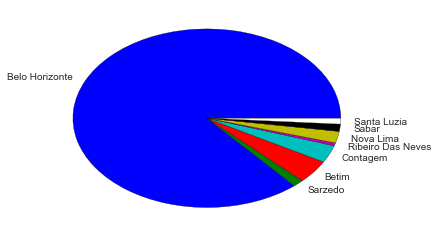

In [30]:
cidade = []
total = []
for item in total_rua_cidades:
    total.append(item["TotalRuas"])
    cidade.append(item["_id"].encode('ascii', 'ignore'))
plt.pie(x=total,labels=cidade)

## 5. Conclusão

## 6. Referências

In [ ]:
http://wiki.openstreetmap.org/wiki/Belo_Horizonte
http://wiki.openstreetmap.org/wiki/WikiProject_Brazil
http://overpass-api.de/api/map?bbox=-44.3092,-20.0979,-43.6116,-19.7376
